In [1]:
from gnn_scheduler.jssp import JobShopInstance, Operation

In [2]:
# Definiendo los trabajos con sus operaciones
jobs = [
    [
        Operation(machine_id=0, duration=1),
        Operation(machine_id=1, duration=1),
        Operation(machine_id=2, duration=7),
    ],
    [
        Operation(machine_id=1, duration=5),
        Operation(machine_id=2, duration=1),
        Operation(machine_id=0, duration=1),
    ],
    [
        Operation(machine_id=2, duration=1),
        Operation(machine_id=0, duration=3),
        Operation(machine_id=1, duration=2),
    ],
]
# We can now create a `JobShopInstance` object from this list of jobs:
jssp = JobShopInstance(jobs, name="Ejemplo")

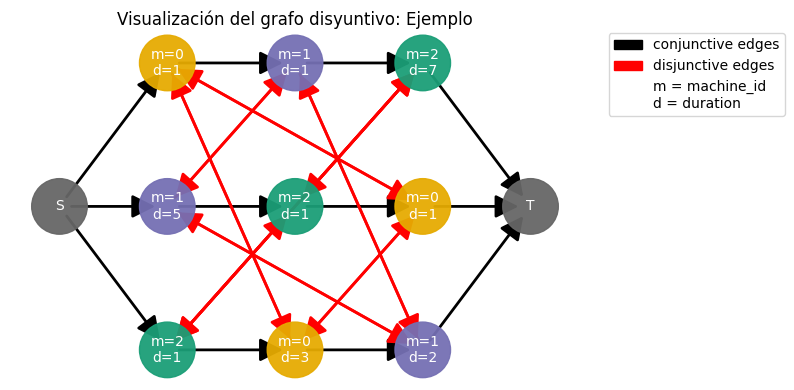

In [8]:
jssp.disjunctive_graph.plot(figsize=(6, 4), title="Visualización del grafo disyuntivo: Ejemplo");

In [15]:
from gnn_scheduler.jssp.solvers import CPSolver

# Definiendo el solver
solver = CPSolver(jssp)
schedule = solver.solve()
schedule

{'J0M0P0': 0,
 'J0M1P1': 1,
 'J0M2P2': 2,
 'J1M1P0': 2,
 'J1M2P1': 9,
 'J1M0P2': 10,
 'J2M2P0': 0,
 'J2M0P1': 1,
 'J2M1P2': 7,
 'makespan': 11,
 'elapsed_time': 0.011046945997804869,
 'status': 'optimal'}

In [10]:
jssp.max_machine_load

9

In [11]:
jssp.max_job_duration

9

In [12]:
11 / 9 - 1

0.22222222222222232

In [39]:
def compute_operation_times(jobs, schedule):
    machine_operations = {}  # Diccionario para operaciones por máquina
    # Iterar sobre cada operación en el horario
    for operation_id, start_time in schedule.items():
        if operation_id in ["makespan", "elapsed_time", "status"]:
            continue  # Ignorar claves que no son operaciones

        # Extraer el id de la máquina de la id de la operación
        machine_id = int(operation_id[3])
        op_job = None
        # Suponemos que la duración de cada operación es de 1 unidad de tiempo
        for job_id, job in enumerate(jobs):
            for pos, operation in enumerate(job):
                if operation.get_id(job_id, pos) == operation_id:
                    end_time = start_time + operation.duration
                    op_job = job_id

        # Añadir la operación a la máquina correspondiente
        if machine_id not in machine_operations:
            machine_operations[machine_id] = []
        machine_operations[machine_id].append((start_time, end_time, op_job))

    return machine_operations

In [45]:
operation_times = compute_operation_times(jobs, schedule)
operation_times

{0: [(0, 1, 0), (10, 11, 1), (1, 4, 2)],
 1: [(1, 2, 0), (2, 7, 1), (7, 9, 2)],
 2: [(2, 9, 0), (9, 10, 1), (0, 1, 2)]}

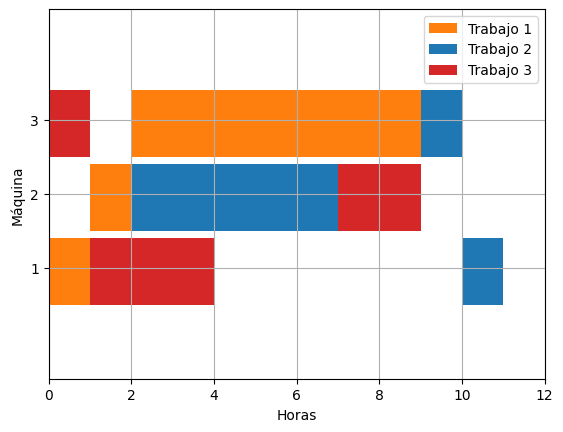

In [47]:
import matplotlib.pyplot as plt

# Declaring a figure "gnt"
fig, gnt = plt.subplots()

# Finding the maximum end time for setting X-axis limit
max_end_time = max(
    max(end for start, end, _ in times) for times in operation_times.values()
)

# Setting Y-axis limits
gnt.set_ylim(0, 50)

# Setting X-axis limits
gnt.set_xlim(0, max_end_time + 1)  # Added a buffer for better visibility

# Setting labels for x-axis and y-axis
gnt.set_xlabel("Horas")
gnt.set_ylabel("Máquina")

# Setting ticks on y-axis
gnt.set_yticks([15, 25, 35])
# Labelling tickes of y-axis
gnt.set_yticklabels(["1", "2", "3"])

# Setting graph attribute
gnt.grid(True)

# Colors for different machines
colors = ["tab:orange", "tab:blue", "tab:red"]

# Plotting the operations for each machine
jobs_added = set()
for machine_id, operations in operation_times.items():
    
    for operation in operations:
        start_time, end_time, job_id = operation
        duration = end_time - start_time
        gnt.broken_barh(
            [(start_time, duration)],
            (machine_id * 10 + 10, 9),
            facecolors=(colors[job_id]),
            label=f"Trabajo {job_id + 1}" if job_id not in jobs_added else None
            ,
        )
        jobs_added.add(job_id)
        
plt.title("Visualización de la solución óptima: Ejemplo")
plt.legend()
plt.show()